In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
import untangle
import tifffile
from read_roi import read_roi_zip
from MastodonFunctions import xml_features, csv_features, ordering_tracks, smoothing_filter, peak_detection, bulk_peak_analysis

# ROI creation

### Data import

In [2]:
# Position 1 and 2 correspond to two embryos from the same experiment
position = 2

In [3]:
# Path to .xml file generated when creating the .hdf5
path_xml = 'D:/Arianne/20191213_134254_29/Position%d_20191213.xml'%position # Path to .xml file

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = 'C:/Users/Arianne/Desktop/Scripts/Python/Archeologist/Data/Position%d-PSMd'%position  #'./Data/Position%d-All'%position 

# Path to roi zip
path_roi = 'D:/Arianne/20191213_134254_29/RoiSet-Position%d.zip'%position

# Path to hdf5
path_hdf5 =  'D:/Arianne/20191213_134254_29/Position%d_20191213.h5'%position

### Image Characteristics

In [4]:
# Time resolution in seconds (how often do you acquire time points)
tr = 90
tr_min = round(tr/60,2) # in minutes

fts = xml_features(path_xml)

# Features from the image obtained from the .xml generated by BigData Viewer
print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
print('There are %d frames in total.'%fts.n_frames)
print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
print('There are %d Z-slices in total'%fts.n_slices)

The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total


### Data organization

In [5]:
# Function to obtain all the spots' information from the .csv file
spots = csv_features(path_csv, path_xml)

# Order the time series according to each individual cell
tracks = ordering_tracks(path_csv, path_xml)

D:\Arianne\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
D:\Arianne\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Plot the data

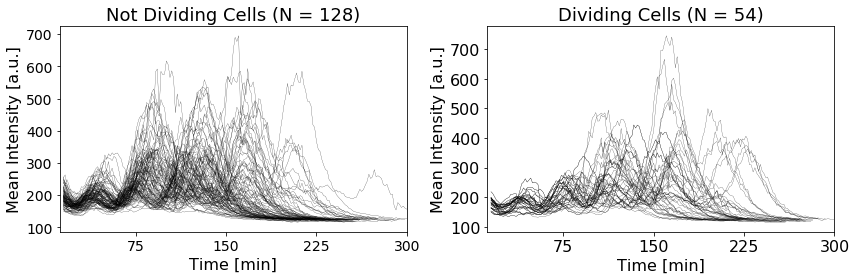

In [6]:
plt.figure(figsize=[12,4])

# Cells that do not divide
plt.subplot(121)
for j in range(tracks.n_tracks_divs):
    if tracks.spots_features['DivID'][j] == 0:
        plt.plot(tracks.spots_features['Frames'][j], tracks.spots_features['Mean1'][j], linewidth=0.2, color='black')

plt.title('Not Dividing Cells (N = %d)'%spots.n_tracks, fontsize = 18)
plt.xlabel('Time [min]', fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr_min)), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Mean Intensity [a.u.]', fontsize=16)
plt.xlim([8,200])

# Dividing Cells
plt.subplot(122)
for j in range(tracks.n_tracks_divs):
    if tracks.spots_features['DivID'][j] > 0:
        plt.plot(tracks.spots_features['Frames'][j], tracks.spots_features['Mean1'][j], linewidth=0.2, color='black')

plt.title('Dividing Cells (N = %d)'%tracks.n_division_tracks, fontsize = 18)
plt.xlabel('Time [min]', fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr_min)), fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Mean Intensity [a.u.]', fontsize=16)
plt.xlim([8,200])

plt.tight_layout()
plt.show()

### Re-arrange the data

In [7]:
trace_save = []
frames_save = []
div_save = []
x_save_ = []
y_save_ = []
z_save_ = []
id_save = []

for j in range(tracks.n_tracks_divs):
    if j!= 74:
        trace_save.append(tracks.spots_features['Mean1'][j])
        frames_save.append(tracks.spots_features['Frames'][j])
        x_save_.append(tracks.spots_features['X'][j])
        y_save_.append(tracks.spots_features['Y'][j])
        z_save_.append(tracks.spots_features['Z'][j])
        div_save.append(tracks.spots_features['DivID'][j])
        id_save.append(tracks.spots_features['ID'][j])

## Spatial Analysis

### Change of coordinate system - from embryo to AP

Using the ROI segmented from the Notochord, we can project the cells into this new coordinate system. But firt, we need to transform the cells' coordinates since they have been registered in time for tracking. Here we implement an inverse transformation to these coordinates and then we project these new coordinates into the notochord ROI. The final result are the cells coordinates in the Anterior-Posterior axis. 

In [8]:
# Read all the ROIs

rois = read_roi_zip(path_roi)

# Number of timepoints
time_points = len(rois)

# Number of points in each segmented notochord line
notochord_points = 32

# Name of ROIs per time point
name_rois = list(rois.keys())

# Initialize where to save the coordinates
x_coords_not = np.zeros((time_points, notochord_points))
y_coords_not = np.zeros((time_points, notochord_points))

for j in range(len(rois)):

    # To know in which frame the analysis happened
    frame = rois[name_rois[j]]['position']-1 #['frame']-1

    x_coords_not[frame,:] = rois[name_rois[j]]['x']
    y_coords_not[frame,:] = rois[name_rois[j]]['y']

### Apply transformations

In [9]:
n_cells = len(frames_save)

# Fill the timepoints where there are no cells tracked with nan
tracks_save = np.ones((n_cells, fts.n_frames))*np.nan

# Save also the x,y positions
x_save = np.ones((n_cells, fts.n_frames))*np.nan
y_save = np.ones((n_cells, fts.n_frames))*np.nan
z_save = np.ones((n_cells, fts.n_frames))*np.nan

# For each track 
for i in range(n_cells):
    # Add the tracked spot to the specific time frame to which it corresponds
    for j,val in enumerate(frames_save[i]):
        tracks_save[i,val] = trace_save[i][j]
        x_save[i,val] = x_save_[i][j]
        y_save[i,val] = y_save_[i][j]
        z_save[i,val] = z_save_[i][j]

In [12]:
obj = untangle.parse(path_xml)

x_save_r = []
y_save_r = []
z_save_r = []
    
for j in range(n_cells):
    
    aux_x = []
    aux_y = []
    aux_z = []
    
    for i in range(0,(time_points-1)*fts.channels,fts.channels):
        
        # XYZ coordinates from mastodon
        xyz_coord = np.array([x_save[j][int(i/2)],y_save[j][int(i/2)],z_save[j][int(i/2)]]).reshape(-1,1)
    
        # Registration from .xml
        registration = np.array(obj.SpimData.ViewRegistrations.ViewRegistration[i].ViewTransform[0].affine.cdata.split(),dtype=float).reshape(3,4)
        
        # Rotation matrix
        R = registration[:,:3] 
        
        # Inverse of rotation matrix
        R_inv = np.linalg.inv(R)
        
        # Translation matrix
        T = registration[:,-1].reshape(-1,1)
        
        final = R_inv@(xyz_coord-T)
        
        # Save xyz de-registered coordinates
        aux_x.append(final[0][0])
        aux_y.append(final[1][0])
        aux_z.append(final[2][0])

    x_save_r.append(aux_x)
    y_save_r.append(aux_y)
    z_save_r.append(aux_z)

### Equidistant points: to increase spatial resolution

In [13]:
def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1), np.linspace(p1[1], p2[1], parts+1))

list(getEquidistantPoints((1,1), (5,5), 4))[0]

x_not_equidist = []
y_not_equidist = []
n_points = 10 # Number of points to add 

for i in range(time_points):
    
    # Initial number of points from fiji
    x = x_coords_not[i].astype(int)
    y = y_coords_not[i].astype(int)
    
    x_aux = []
    y_aux = []
    
    for j in range(notochord_points-1):
        aux = list(getEquidistantPoints((x[j],y[j]),(x[j+1],y[j+1]), n_points))
        
        # For each of the inserted points
        for k in range(len(aux)-1):
            x_aux.append(aux[k][0])
            y_aux.append(aux[k][1])
            
    x_not_equidist.append(x_aux)
    y_not_equidist.append(y_aux)
    
print('Number of timepoints: %d'%np.shape(x_not_equidist)[0])
print('Number of points per timepoint: %d'%np.shape(x_not_equidist)[1])

Number of timepoints: 300
Number of points per timepoint: 310


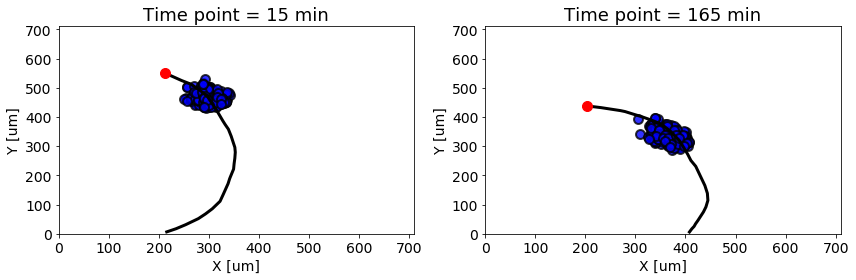

In [14]:
plt.figure(figsize=[12,4])
plt.subplot(121)
tp = 10
plt.plot(np.array(x_not_equidist[tp])*fts.x_pixel, (np.array(y_not_equidist[tp]))*fts.y_pixel, linewidth=3, color='black')
plt.plot(x_not_equidist[tp][0]*fts.x_pixel,(y_not_equidist[tp][0])*fts.y_pixel,'o',color='red', markersize=10)

for j in range(n_cells):
    plt.scatter(x_save_r[j][tp],y_save_r[j][tp], c='blue', edgecolor='black', linewidth=2, s=80, alpha=0.8)

plt.xlim([0,2048*fts.x_pixel])
plt.ylim([0,2048*fts.y_pixel])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('X [um]', fontsize=14)
plt.ylabel('Y [um]', fontsize=14)

plt.title('Time point = %d min'%(tp*tr_min), fontsize=18)

plt.subplot(122)
tp = 110
plt.plot(np.array(x_not_equidist[tp])*fts.x_pixel, (np.array(y_not_equidist[tp]))*fts.y_pixel, linewidth=3, color='black')
plt.plot(x_not_equidist[tp][0]*fts.x_pixel,(y_not_equidist[tp][0])*fts.y_pixel,'o',color='red', markersize=10)

for j in range(n_cells):
     plt.scatter(x_save_r[j][tp],y_save_r[j][tp], c='blue', edgecolor='black', linewidth=2, s=80, alpha=0.8)

plt.xlim([0,2048*fts.x_pixel])
plt.ylim([0,2048*fts.y_pixel])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('X [um]', fontsize=14)
plt.ylabel('Y [um]', fontsize=14)

plt.title('Time point = %d min'%(tp*tr_min), fontsize=18)

plt.tight_layout()
plt.show()

### Show the cells in the maxprojection

In [63]:
# Read the data
f = h5py.File(path_hdf5, 'r')
    
tp = 10
#Get the HDF5 group
group = f['t%.5d'%tp]

# channel 
channel = 's01'

# Subsampling 
subsampling = '0'

max1 = np.max(group[channel][subsampling]['cells'][60:120],axis=0)

tp = 80
#Get the HDF5 group
group = f['t%.5d'%tp]

# channel 
channel = 's01'

# Subsampling 
subsampling = '0'

max2 = np.max(group[channel][subsampling]['cells'][60:120],axis=0)

tp = 160
#Get the HDF5 group
group = f['t%.5d'%tp]

# channel 
channel = 's01'

# Subsampling 
subsampling = '0'

max3 = np.max(group[channel][subsampling]['cells'][60:120],axis=0)

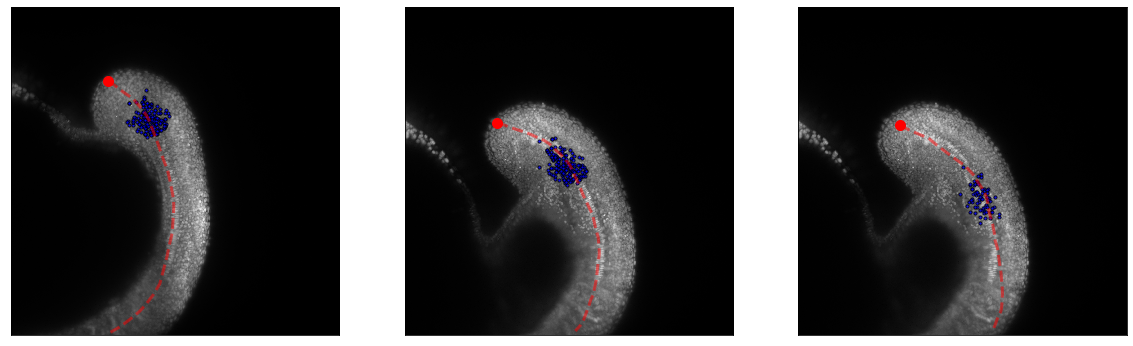

In [64]:
plt.figure(figsize=[20,20])

plt.subplot(131)
plt.imshow(max1, cmap='gray')
tp = 10
plt.plot(np.array(x_not_equidist[tp]), (np.array(y_not_equidist[tp])), linewidth=3, color='red', linestyle='dashed',\
        alpha=0.5)

plt.plot(x_not_equidist[tp][0],(y_not_equidist[tp][0]),'o',color='red', markersize=10)

for j in range(n_cells):
    plt.scatter(x_save_r[j][tp]/fts.x_pixel,y_save_r[j][tp]/fts.y_pixel, c='blue', edgecolor='black', linewidth=1, s=10, alpha=0.8)

plt.xlim([0,2048])
plt.ylim([0,2048])

plt.xticks([])
plt.yticks([])

plt.subplot(132)
plt.imshow(max2, cmap='gray')
tp = 80
plt.plot(np.array(x_not_equidist[tp]), (np.array(y_not_equidist[tp])), linewidth=3, color='red', linestyle='dashed',\
        alpha=0.5)

plt.plot(x_not_equidist[tp][0],(y_not_equidist[tp][0]),'o',color='red', markersize=10)

for j in range(n_cells):
    plt.scatter(x_save_r[j][tp]/fts.x_pixel,y_save_r[j][tp]/fts.y_pixel, c='blue', edgecolor='black', linewidth=1, s=10, alpha=0.8)

plt.xlim([0,2048])
plt.ylim([0,2048])

plt.xticks([])
plt.yticks([])

plt.subplot(133)
plt.imshow(max2, cmap='gray')
tp = 160
plt.plot(np.array(x_not_equidist[tp]), (np.array(y_not_equidist[tp])), linewidth=3, color='red', linestyle='dashed',\
        alpha=0.5)

plt.plot(x_not_equidist[tp][0],(y_not_equidist[tp][0]),'o',color='red', markersize=10)

for j in range(n_cells):
    plt.scatter(x_save_r[j][tp]/fts.x_pixel,y_save_r[j][tp]/fts.y_pixel, c='blue', edgecolor='black', linewidth=1, s=10, alpha=0.8)

plt.xlim([0,2048])
plt.ylim([0,2048])

plt.xticks([])
plt.yticks([])

plt.show()


## Create ROIs for Stardist

In [199]:
def crop_hdf5(x,y,z,x_pixel,y_pixel,z_pixel,path_hdf5,tp,cell,x_crop,y_crop,z_crop,data_path):
    # Convert data into 
    x_val = int(np.round(x/x_pixel))
    y_val = int(np.round(y/y_pixel))
    z_val = int(np.round(z/z_pixel))
    
    # Read the data
    f = h5py.File(path_hdf5, 'r')
    
    #Get the HDF5 group
    group = f['t%.5d'%tp]
    
    # Create the Z stack
    aux = []
    z_vals_crop = np.arange(z_val-z_crop,z_val+z_crop,1)
    for i in z_vals_crop:
        aux += [group[channel][subsampling]['cells'][i][y_val-y_crop:y_val+y_crop,x_val-x_crop:x_val+x_crop]]
        
    tifffile.imsave('%s/Cell_%d_T_%.3d.tif'%(data_path, cell,tp), np.array(aux))

In [215]:
n_cells_train = 5 # Number of cells for the trainning
n_tps_train = 5 # Number of timepoints per cell for the trainning

# Cropping
x_crop = 15
y_crop = 15
z_crop = 4

# channel 
channel = 's01'

# Subsampling 
subsampling = '0'

In [216]:
# Create a list to save the tiff crops for stardist
training_data_path = os.path.join("./","training-data")
if not os.path.exists(training_data_path):
    os.mkdir(training_data_path)

In [217]:

for i in range(n_cells_train):
    # Select a random number of a cell
    cell_rand = np.random.randint(n_cells)
    
    # Choose no nan data
    no_nan_tp = np.arange(0,time_points-1,1)[~np.isnan(x_save_r[cell_rand])]
    tps_rand = np.random.choice(no_nan_tp, n_tps_train)
    
    # For each timepoint, for that cell
    for j in tps_rand:
        # X,Y,Z values for that timepoint & for that cell
        x = x_save_r[cell_rand][j]
        y = y_save_r[cell_rand][j]
        z = z_save_r[cell_rand][j]
        
        crop_hdf5(x,y,z,fts.x_pixel,fts.y_pixel,fts.z_pixel,path_hdf5,j,cell_rand,x_crop,y_crop,z_crop,training_data_path)
        

In [74]:


# Cropping
x_crop = 20
y_crop = 20
z_crop = 5

# channel 
channel = 's01'

# Subsampling 
subsampling = '0'

In [59]:
x_val = int(np.round(x_save_r[cell][tp]/fts.x_pixel))
y_val = int(np.round(y_save_r[cell][tp]/fts.y_pixel))
z_val = int(np.round(z_save_r[cell][tp]/fts.z_pixel))

In [60]:
# Read the data
f = h5py.File(path_hdf5, 'r')
    
#Get the HDF5 group
group = f['t%.5d'%tp]

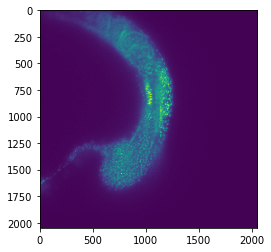

In [62]:
plt.imshow(group[channel][subsampling]['cells'][z_val])

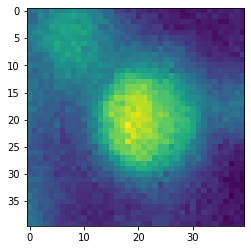

In [88]:
plt.imshow(group[channel][subsampling]['cells'][z_val][y_val-y_crop:y_val+y_crop,x_val-x_crop:x_val+x_crop])

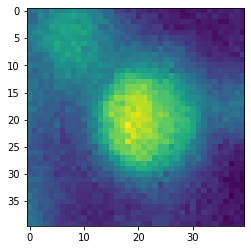

In [72]:
plt.imshow(group[channel][subsampling]['cells'][z_val][y_val-y_crop:y_val+y_crop,x_val-x_crop:x_val+x_crop])

## Where are the divisions happening?

### Project the positions into the line of reference: the notochord

We use the most posterior point as out 0 position, meaning that the closer to the tailbud, the smaller the distance to the reference will be. 

In [69]:
# Projection function

def projectionNotochord(x,y,x_not,y_not):
    # Reference pointa
    x_0 = x_not[0]
    y_0 = y_not[0]
    
    # Calculate the projection to the notochord line
    ind_proj = np.argmin(np.sqrt((x-x_not)**2+(y-y_not)**2))
    
    # Calculate the distance from the projection to the reference point
    distance_to_ref = np.sqrt((x_not[ind_proj]-x_0)**2+(y_not[ind_proj]-y_0)**2)
    
    return distance_to_ref

In [76]:
division_tp = []
division_x = []
division_y = []
division_z = []
proj_dist = []
# Each division ID is a number from 1:N_divisions
div_ids = np.unique(np.array(tracks.spots_features['DivID']))[1:]

# Find the timepoit where the cells divide
def Diff(li1, li2): 
    return np.where(np.array(list1)==[item for item in list1 if item not in list2][0])[0]

# For each possible division
for i in range(len(div_ids)):
    idxs = np.where(np.array(div_save)==div_ids[i])[0]
    
    # IDs for each timepoint for the sibling cells
    list1 = id_save[idxs[0]]
    list2 = id_save[idxs[1]]
    
    # The first timepoint where the IDs are different - 1, is when they divide
    ind = Diff(list1, list2) - 1
    ind = int(ind)
    
    # Timepoint of division
    tp = frames_save[idxs[0]][ind]
    
    # Save the timpoint, X,Y and Z position
    division_tp.append(tp)
    division_x.append(x_save_r[idxs[0]][ind])
    division_y.append(y_save_r[idxs[0]][ind])
    division_z.append(z_save_r[idxs[0]][ind])
    
    # Find the projected value
    distance = projectionNotochord(x_save_r[idxs[0]][ind], y_save_r[idxs[0]][ind],\
                                np.array(x_not_equidist[tp])*fts.x_pixel, np.array(y_not_equidist[tp])*fts.x_pixel)

    proj_dist.append(distance)

In [82]:
# Project the rest of the cells

proj_dist_all = []

# For each cell tracked
for i in range(n_cells):
    
    # For each of the timepoints
    for j in (frames_save[i]):
        
        # Find the projected value
        distance = projectionNotochord(x_save_r[i][j], y_save_r[i][j],\
                                np.array(x_not_equidist[j])*fts.x_pixel, np.array(y_not_equidist[j])*fts.x_pixel)

        proj_dist_all.append(distance)
        
        

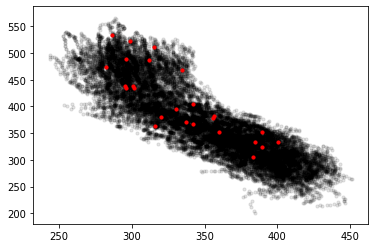

In [66]:
for i in range(n_cells):
    plt.scatter(x_save_r[i],y_save_r[i], s=10, color='black', alpha=0.1)
    
plt.scatter(division_x, division_y, s=10, color='red')

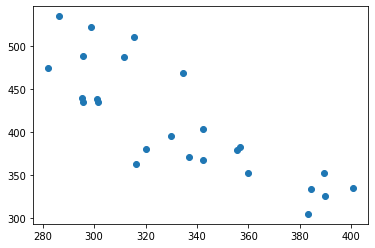

In [58]:
plt.scatter(division_x, division_y)

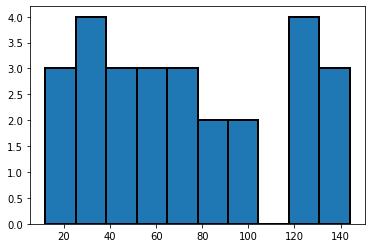

In [62]:
plt.hist(division_tp, edgecolor='black', linewidth=2);

## Distance to most posterior point in the TB

In [ ]:
for i in range(n_cells):
    
tp = 10
plt.plot(np.array(x_not_equidist[tp])*fts.x_pixel, (np.array(y_not_equidist[tp]))*fts.y_pixel, linewidth=3, color='black')
plt.plot(x_not_equidist[tp][0]*fts.x_pixel,(y_not_equidist[tp][0])*fts.y_pixel,'o',color='red', markersize=10)

for j in range(n_cells):
    plt.scatter(x_save_r[j][tp],y_save_r[j][tp], c='blue', edgecolor='black', linewidth=2, s=80, alpha=0.8)

plt.xlim([0,2048*fts.x_pixel])
plt.ylim([0,2048*fts.y_pixel])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('X [um]', fontsize=14)
plt.ylabel('Y [um]', fontsize=14)

plt.title('Time point = %d min'%(tp*tr_min), fontsize=18)


plt.tight_layout()
plt.show()